In [1]:
import numpy as np

In [2]:
%reload_ext autoreload
%autoreload 1
%aimport train

In [3]:
import tensorflow as tf

import tflearn

In [4]:
model = train.build_model()
model.load('detect_cnn.tflearn')

In [5]:
pool = model.net.graph.get_tensor_by_name('MaxPool2D_1/MaxPool:0')
weights = model.net.graph.get_tensor_by_name('FullyConnected/W:0')

In [6]:
graph_large = tf.Graph()
with graph_large.as_default():
    network_large = train.build_network(image_size=(288, 512))

In [7]:
def transplant_params(name, ga, gb, sa, sb):
    opa = ga.get_operation_by_name(name)
    with graph_large.as_default():
        tf.get_variable_scope().reuse_variables()
        varb = tf.get_variable(name)
        vala = sa.run(opa.outputs[0])
        sb.run(tf.assign(varb, vala))

In [8]:
sess = tf.Session(graph=graph_large)

In [9]:
transplant_params('Conv2D/W', model.net.graph, graph_large, model.session, sess)
transplant_params('Conv2D/b', model.net.graph, graph_large, model.session, sess)
transplant_params('Conv2D_1/W', model.net.graph, graph_large, model.session, sess)
transplant_params('Conv2D_1/b', model.net.graph, graph_large, model.session, sess)

In [11]:
fc_filter_weights = weights.eval(session=model.session).reshape(16, 16, 32, 2)

with graph_large.as_default():
    pool_large = graph_large.get_tensor_by_name('MaxPool2D_1/MaxPool:0')
    fc_filter = tf.Variable(fc_filter_weights, dtype=tf.float32, name='fc_filter')
    output_large = tf.nn.conv2d(pool_large, filter=fc_filter, strides=[1, 1, 1, 1], padding='VALID')

In [12]:
import cv2

In [19]:
im_full = cv2.imread('images_full/shark_full_1.jpg')

In [14]:
input_large = graph_large.get_tensor_by_name('InputData/X:0')

In [15]:
fc_filter.initializer.run(session=sess)

In [22]:
im_out_large = sess.run(output_large, feed_dict={input_large: im_full[np.newaxis,:,:,:]})

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

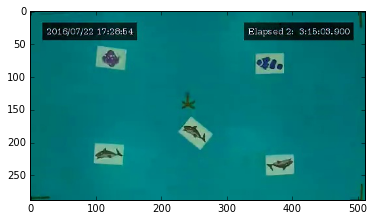

In [20]:
plt.imshow(im_full)

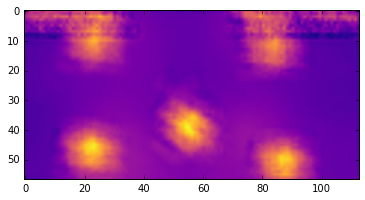

In [23]:
plt.imshow(im_out_large[0,:,:,1])